In [1]:
import os
import sys
import yaml
import math
import itertools

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts, flatten_dict
from experiments.dispatch.dispatch_utils import nested_dict_to_option_strings

# plotting
# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

# Investigating applying damping to the PVI updates
Need to apply damping to the PVI algorithm to prevent over corrections in the updates. Gridded over one seed runs for a number of clients and damping factors. THis time we're damping the individual client updates to see what happens. This should keep the client and server in sync.

In [2]:
with open('../experiment_configs/PVI_client_damping_investigation.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)
    
experiment_config = flatten_dict(experiment_config)

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)

experiment_config

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
dp_configs = [dict(item) for item in product]

adult_configs = [d for d in dp_configs if d['dataset.name'] == 'adult']
abalone_configs = [d for d in dp_configs if d['dataset.name'] == 'abalone']

Ms = experiment_config['dataset_dist.M']
damping_factors = experiment_config['PVI_settings.client_damping_factor']

In [3]:
results_access = SacredExperimentAccess(database_name='PVI_client_damping_investigation')

In [4]:
adult_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in adult_configs]
abalone_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in abalone_configs]

adult_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_experiments]
abalone_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in abalone_experiments]

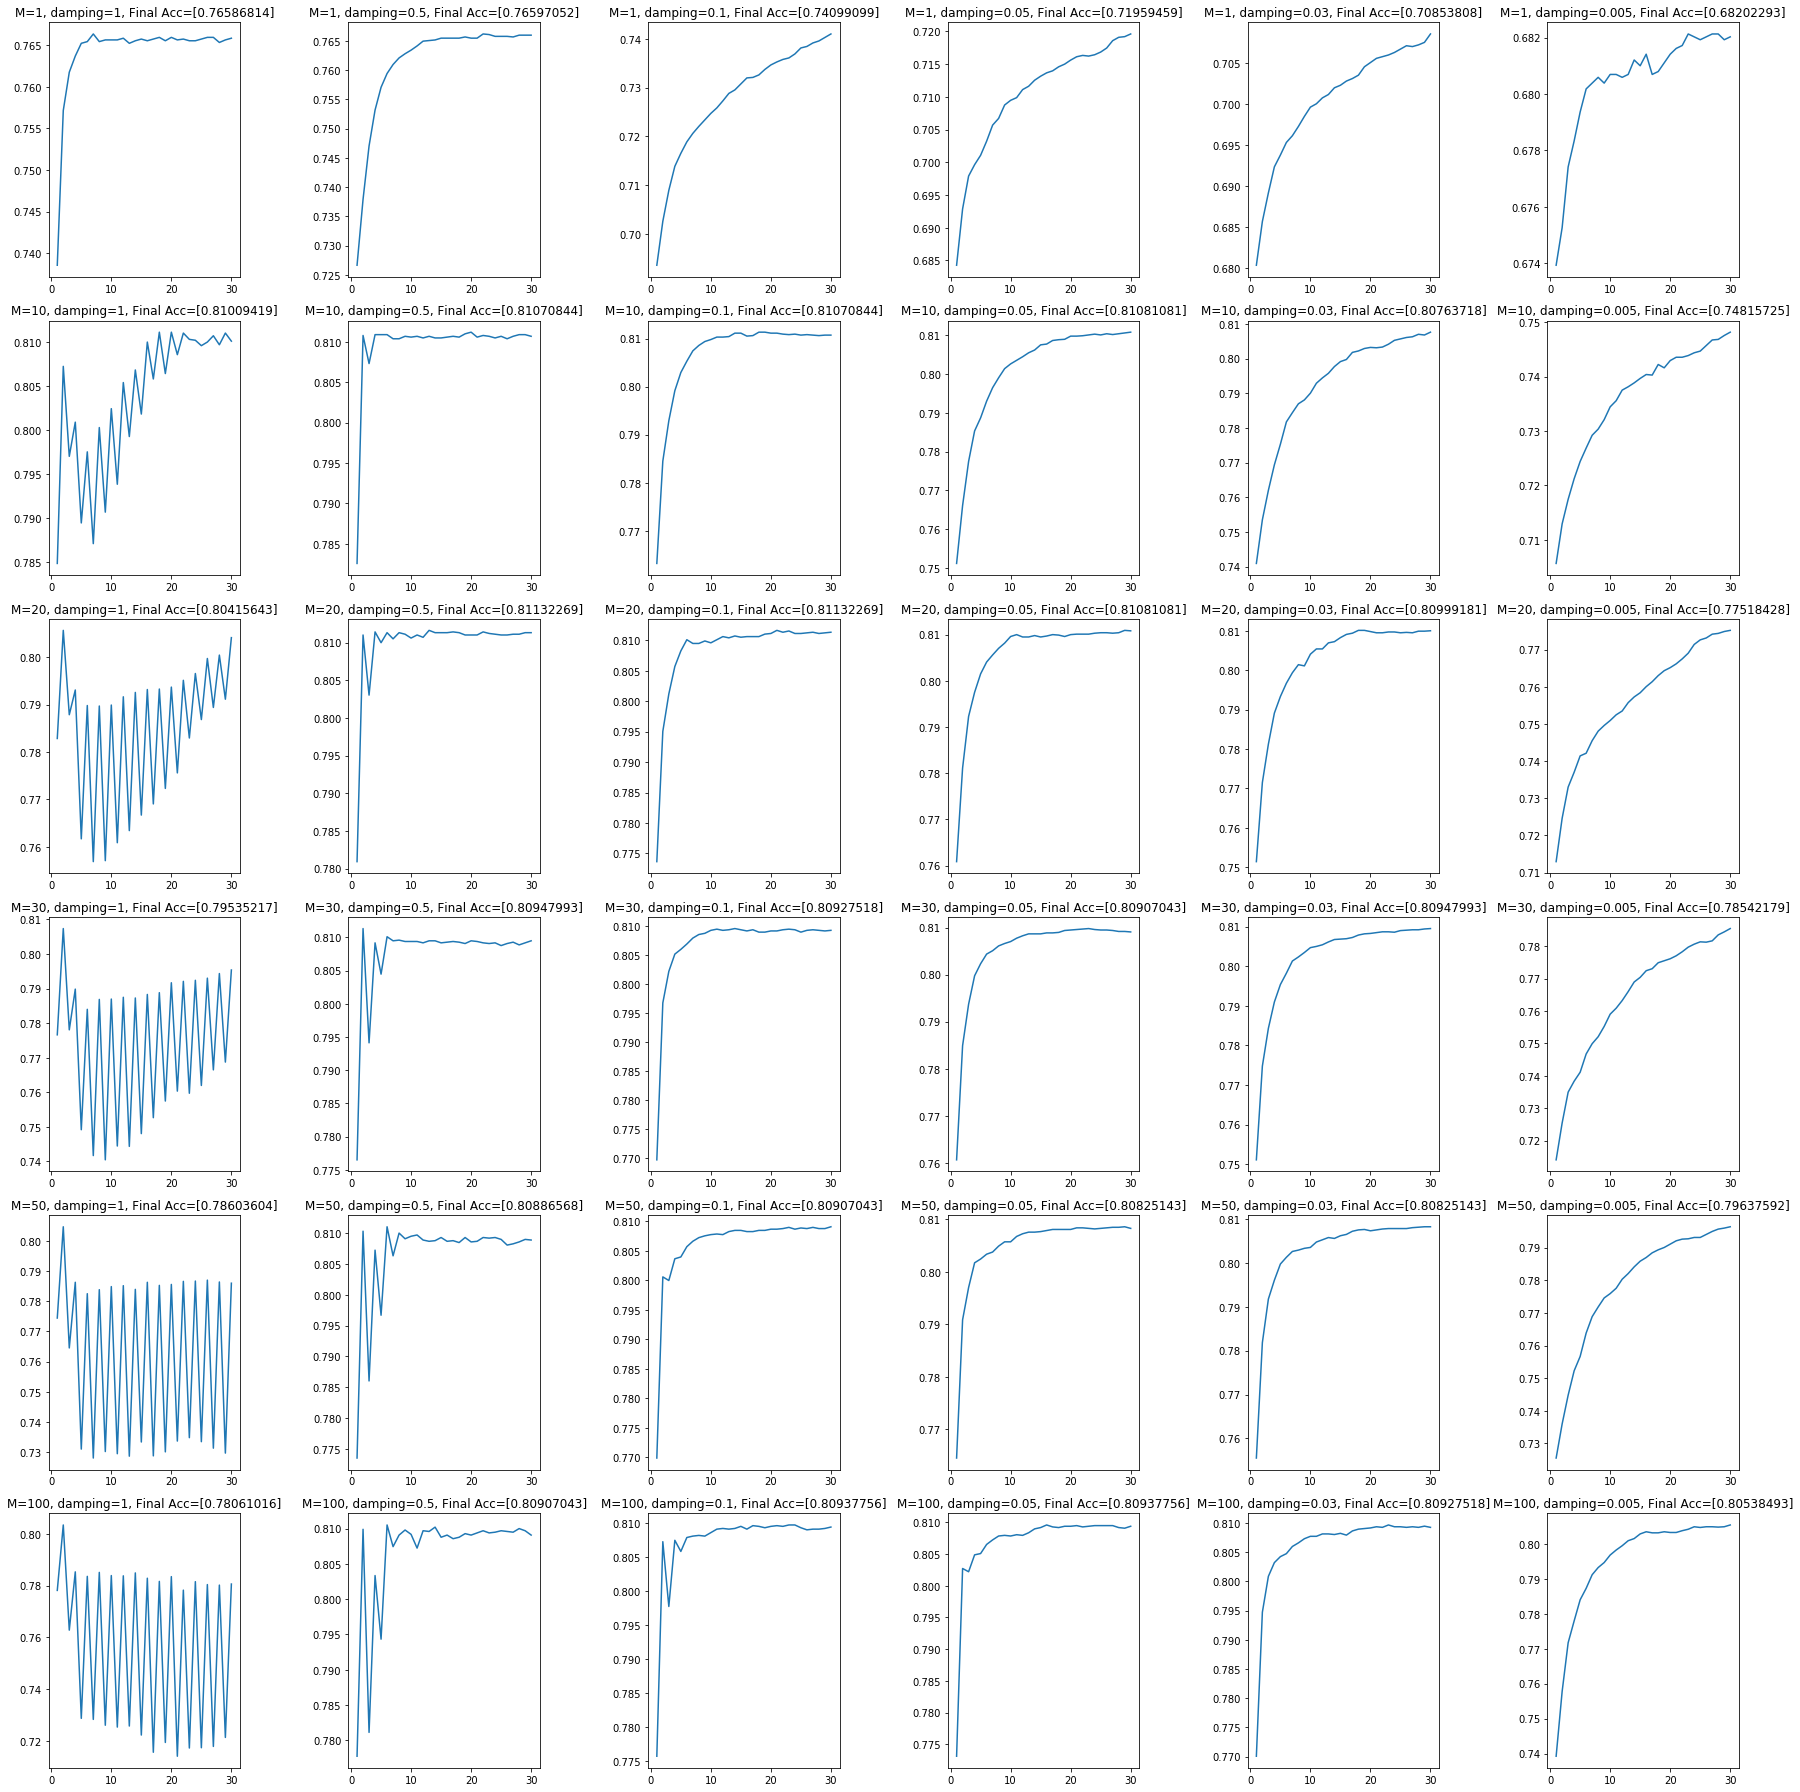

In [5]:
plt.figure(figsize=(25,25))
rows = len(Ms)
cols = len(damping_factors)

for config, experiment, metrics in zip(adult_configs, adult_experiments, adult_metrics):
    M = config['dataset_dist.M']
    damping_factor = config['PVI_settings.client_damping_factor']
    
    M_index = Ms.index(M)
    damping_index = damping_factors.index(damping_factor)
    
    plt.subplot(rows, cols, M_index * cols + damping_index + 1)
    
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T
    
    plt.plot(steps, values)
    plt.title(f'M={M}, damping={damping_factor}, Final Acc={values[-1]}')
    
plt.tight_layout()

This damping is clearly good. The relationship between $M$ and the damping factor is not quite clear. Next were going to look at damping DP-PVI algorithms. Go to `Tuning DP-PVI (q=1 version) for M=100 on adult` for more